<a href="https://colab.research.google.com/github/ffg-kom/mapping_evolution/blob/master/mapping_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

Tutorials that helped in creating this notebook:
* Basics - https://colab.research.google.com/github/nestauk/im_tutorials/blob/master/notebooks/01_intro_to_pandas_tutorial.ipynb
* Networks - https://colab.research.google.com/github/nestauk/im_tutorials/blob/master/notebooks/networkScience.ipynb

In [0]:
%load_ext autoreload
%autoreload 2

# install im_tutorial package
!pip install git+https://github.com/nestauk/im_tutorials.git
!pip install pybind11
!pip install cpalgorithm
!pip install networkx
!pip install seaborn

# Needed to make some of the drag and dropping work
!pip install -U bokeh

In [0]:
# numpy for mathematical functions
import numpy as np
# pandas for handling tabular data
import pandas as pd

# importing useful Python utility libraries we'll need
from collections import Counter, defaultdict
import itertools

# matplotlib for static plots
import matplotlib.pyplot as plt
from matplotlib import pylab

# makes the plots prettier
import seaborn

# networkx for the analysis of graphs
import networkx as nx

#from im_tutorials.utilities import chunks
from im_tutorials.data import *

# Useful data structure to count occurances
from collections import Counter

#Iteration lib
import itertools as it

# `python-louvain` imports as `community`
import community

# data
from im_tutorials.data.cordis import h2020_projects
from im_tutorials.data.cordis import cordis_table

# network graphics
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Category20, Spectral4
from bokeh.palettes import Spectral6
from bokeh.models import Circle, MultiLine, HoverTool, TapTool, BoxSelectTool
from bokeh.models import ColumnDataSource, LinearColorMapper, PointDrawTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges
output_notebook()

The following block prepares a function that helps with building network graphics with bokeh-support. However, weights of edged are not taken into account. Hints for possible adaption might be found here for further reference: https://stackoverflow.com/questions/49136867/networkx-plotting-in-bokeh-how-to-set-edge-width-based-on-graph-edge-weight

In [0]:
from bokeh.palettes import Spectral4
from bokeh.transform import factor_cmap
palette = seaborn.cubehelix_palette(21)
pal_hex_lst = palette.as_hex()
def bokeh_plot(G,attribute=None,title='',factor=False):

  # Create a plot and give it some basic features.
  plot = figure(title=title,
              x_range=(-2.1,2.1), y_range=(-2.1,2.1),
             )
  pos = nx.spring_layout(G, weight='association_strength', scale=2)
  # Use the renderer built in to `bokeh` to transform our Graph
  # object into something that `bokeh` can plot.
  graph_renderer = from_networkx(G, pos, center=(0,0))
  
  # Draw glyphs for our nodes and assign properties for interactions.
  if attribute!=None:
    idx = graph_renderer.node_renderer.data_source.data['index']
    data = [attribute[x] for x in idx]
    graph_renderer.node_renderer.data_source.data['node_color'] = data

    if factor:
      data = [str(attribute[x]) for x in idx]
      graph_renderer.node_renderer.data_source.data['node_color'] = data
      uniItems = list(set(data))
      uniItemsNum = min(20,len(uniItems))
      mapper = factor_cmap('node_color', palette=Category20[uniItemsNum], factors=uniItems)
      graph_renderer.node_renderer.glyph = Circle(size=10,fill_color= mapper) #, line_color=None)

    else:
      mapper = LinearColorMapper(palette=pal_hex_lst, low=min(attribute.values()), high=max(attribute.values()))
      graph_renderer.node_renderer.glyph = Circle(size=10,fill_color={'field': 'node_color', 'transform': mapper}) #, line_color=None)
  else:
    graph_renderer.node_renderer.glyph = Circle(size=10,fill_color='blue') #, line_color=None)

    
  graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
  graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])                               
  graph_renderer.node_renderer.muted_glyph = Circle(size=15, fill_alpha=0.9)
  
  # Draw glyphs for edges and assign properties for interactions.
  graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=1, line_width=1)
  graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1.5)
  graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1.5)
  
  # Add the ability to select nodes.
  graph_renderer.selection_policy = NodesAndLinkedEdges()
  # Add a hover tool, that allows us to investigate nodes with a tooltip. 
  hover = HoverTool(tooltips=[("Name:", "@name")])
  
  
  # Put everything on the plot.
  graph_renderer.node_renderer.data_source.data['name'] =graph_renderer.node_renderer.data_source.data['index']

  fill_color='color'
  plot.add_tools(hover, TapTool(), BoxSelectTool())
  plot.renderers.append(graph_renderer)

  show(plot)

  # Uncomment this line if using google colab
  output_notebook()

# Loading data

We are working with a subset of data on projects and organisations that have been funded through the European Frameworkprogrammes for Research and Innovation.

**We concentrate on:**
* Horizon 2020 (projects since 2014)
* Private for-profit entities (excluding Higher or Secondary Education Establishments)

If you're interested, you can also run this workbook for other groups of organisations. The respective filtering occurs in the very last step of this section.

In [0]:
# load tables
cordis_o_df = cordis_table('organisations')
cordis_p_df = cordis_table('projects')
cordis_p_o_df = cordis_table('project_organisations')
cordis_pub_df = cordis_table('publications')

# merge them
cordis_project_orgs_df = cordis_p_o_df.merge(
  cordis_o_df, left_on='organization_id', right_on='id', how='left'
)
cordis_project_orgs_df = cordis_project_orgs_df.merge(
  cordis_p_df, left_on='project_rcn', right_on='rcn', how='left'
)

cordis_project_orgs_df.rename( columns={'contribution': 'ec_contribution_organization'
                                        , 'ec_contribution': 'ec_contribution_project'
                                        , 'total_cost': 'total_cost_project'
                                       }, inplace=True )

# add number of partners per project as a column
count_partners_df = cordis_project_orgs_df[['project_rcn', 'organization_id']].groupby( by='project_rcn' ).count()
count_partners_df.rename( columns={'organization_id': 'number_of_partners'}, inplace=True )

cordis_project_orgs_df = cordis_project_orgs_df.merge(
  count_partners_df, on='project_rcn', how='left'
)

# add number of publications per project as a column
count_publications_df = cordis_pub_df[['id', 'project_rcn']].groupby( by='project_rcn' ).count()
count_publications_df.rename( columns={'id': 'number_of_publications'}, inplace=True )

cordis_project_orgs_df = cordis_project_orgs_df.merge(
  count_publications_df, on='project_rcn', how='left'
)


# preparing dictionaries to effectively group data
dict_funding_schemes_along_programmes = {'BBI-CSA - Bio-based Industries Coordination and Support action': 'Bio-based Industries',
                                         'BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration': 'Bio-based Industries', 
                                         'BBI-IA-FLAG - Bio-based Industries Innovation action - Flagship': 'Bio-based Industries',
                                         'BBI-RIA - Bio-based Industries Research and Innovation action': 'Bio-based Industries', 
                                         'COFUND-EJP - COFUND (European Joint Programme)': '(general)', 
                                         'COFUND-PCP - COFUND (PCP)': '(general)', 
                                         'CS2-CSA - Coordination & support action': 'Clean Sky 2', 
                                         'CS2-IA - Innovation action': 'Clean Sky 2', 
                                         'CS2-RIA - Research and Innovation action': 'Clean Sky 2', 
                                         'CSA - Coordination and support action': '(general)', 
                                         'CSA-LS - CSA Lump sum': '(general)', 
                                         'ECSEL-CSA - ECSEL Coordination & Support action': 'ECSEL (Electronic Components and Systems for European Leadership)', 
                                         'ECSEL-IA - ECSEL Innovation Action': 'ECSEL (Electronic Components and Systems for European Leadership)', 
                                         'ECSEL-RIA - ECSEL Research and Innovation Action': 'ECSEL (Electronic Components and Systems for European Leadership)', 
                                         'ERA-NET-Cofund - ERA-NET Cofund': 'ERA-NET', 
                                         'ERC-ADG - Advanced Grant': 'ERC (European Research Council)', 
                                         'ERC-COG - Consolidator Grant': 'ERC (European Research Council)', 
                                         'ERC-POC - Proof of Concept Grant': 'ERC (European Research Council)', 
                                         'ERC-POC-LS - ERC Proof of Concept Lump Sum Pilot': 'ERC (European Research Council)', 
                                         'ERC-STG - Starting Grant': 'ERC (European Research Council)', 
                                         'FCH2-CSA - Coordination & support action': 'FCH2 (Fuel Cells and Hydrogen 2)', 
                                         'FCH2-IA - Innovation action': 'FCH2 (Fuel Cells and Hydrogen 2)', 
                                         'FCH2-RIA - Research and Innovation action': 'FCH2 (Fuel Cells and Hydrogen 2)', 
                                         'H2020-EEN-SGA - Specific Grant Agreement Enterprise Europe Network (EEN)': 'SME (Small and medium-sized Enterprises)', 
                                         'IA - Innovation action': '(general)', 
                                         'IA-LS - Innovation action Lump Sum': '(general)', 
                                         'IMI2-CSA - Coordination & support action': 'IMI2 (Innovative Medicines Initiative)', 
                                         'IMI2-RIA - Research and Innovation action': 'IMI2 (Innovative Medicines Initiative)', 
                                         'MSCA-COFUND-DP - Doctoral programmes': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-COFUND-FP - Fellowship programmes': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-IF-EF-CAR - CAR â€“ Career Restart panel': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-IF-EF-RI - RI â€“ Reintegration panel': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-IF-EF-SE - Society and Enterprise panel': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-IF-EF-ST - Standard EF': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-IF-GF - Global Fellowships': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-ITN-EID - European Industrial Doctorates': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-ITN-EJD - European Joint Doctorates': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-ITN-ETN - European Training Networks': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'MSCA-RISE - Marie SkÅ‚odowska-Curie Research and Innovation Staff Exchange (RISE)': 'MSCA (Marie Skłodowska-Curie Actions)', 
                                         'PCP - Pre-Commercial Procurement': 'PCP & PPI (Pre-commercial or public Procurement)', 
                                         'PPI - Public Procurement of Innovative solutions': 'PCP & PPI (Pre-commercial or public Procurement)', 
                                         'RIA - Research and Innovation action': '(general)', 
                                         'RIA-LS - Research and Innovation action Lump Sum': '(general)', 
                                         'SESAR-CSA - Coordination and Support Action': 'SESAR (Single European Sky)', 
                                         'SESAR-IA - Innovation action': 'SESAR (Single European Sky)', 
                                         'SESAR-RIA - Research and Innovation action': 'SESAR (Single European Sky)', 
                                         'SGA-CSA - Specific Grant agreement and Coordination and Support Action': '(general)', 
                                         'SGA-RIA - SGA-RIA': '(general)', 
                                         'Shift2Rail-CSA - Coordination and Support Action': 'Shift2Rail', 
                                         'Shift2Rail-IA - Innovation action': 'Shift2Rail', 
                                         'Shift2Rail-IA-LS - Innovation Action Lump-Sum': 'Shift2Rail', 
                                         'Shift2Rail-RIA - Research and Innovation action': 'Shift2Rail', 
                                         'Shift2Rail-RIA-LS - Shift2Rail Research and Innovation Action Lump-Sum': 'Shift2Rail', 
                                         'SME-1 - SME instrument phase 1': 'SME (Small and medium-sized Enterprises)', 
                                         'SME-2 - SME instrument phase 2': 'SME (Small and medium-sized Enterprises)'
                                        }

dict_funding_schemes_along_actions = {'BBI-CSA - Bio-based Industries Coordination and Support action': 'CSA (Coordination and Support Action)',
                                      'BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration': 'IA (Innovation Action)',
                                      'BBI-IA-FLAG - Bio-based Industries Innovation action - Flagship': 'IA (Innovation Action)',
                                      'BBI-RIA - Bio-based Industries Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'COFUND-EJP - COFUND (European Joint Programme)': 'COFUND',
                                      'COFUND-PCP - COFUND (PCP)': 'COFUND',
                                      'CS2-CSA - Coordination & support action': 'CSA (Coordination and Support Action)',
                                      'CS2-IA - Innovation action': 'IA (Innovation Action)',
                                      'CS2-RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'CSA - Coordination and support action': 'CSA (Coordination and Support Action)',
                                      'CSA-LS - CSA Lump sum': 'CSA (Coordination and Support Action)',
                                      'ECSEL-CSA - ECSEL Coordination & Support action': 'CSA (Coordination and Support Action)',
                                      'ECSEL-IA - ECSEL Innovation Action': 'IA (Innovation Action)',
                                      'ECSEL-RIA - ECSEL Research and Innovation Action': 'RIA (Research and Innovation Action)',
                                      'ERA-NET-Cofund - ERA-NET Cofund': 'COFUND',
                                      'ERC-ADG - Advanced Grant': 'Grant',
                                      'ERC-COG - Consolidator Grant': 'Grant',
                                      'ERC-POC - Proof of Concept Grant': 'Grant',
                                      'ERC-POC-LS - ERC Proof of Concept Lump Sum Pilot': 'Grant',
                                      'ERC-STG - Starting Grant': 'Grant',
                                      'FCH2-CSA - Coordination & support action': 'CSA (Coordination and Support Action)',
                                      'FCH2-IA - Innovation action': 'IA (Innovation Action)',
                                      'FCH2-RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'H2020-EEN-SGA - Specific Grant Agreement Enterprise Europe Network (EEN)': 'SME (Small and medium-sized Enterprises)',
                                      'IA - Innovation action': 'IA (Innovation Action)',
                                      'IA-LS - Innovation action Lump Sum': 'IA (Innovation Action)',
                                      'IMI2-CSA - Coordination & support action': 'CSA (Coordination and Support Action)',
                                      'IMI2-RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'MSCA-COFUND-DP - Doctoral programmes': 'COFUND',
                                      'MSCA-COFUND-FP - Fellowship programmes': 'COFUND',
                                      'MSCA-IF-EF-CAR - CAR â€“ Career Restart panel': 'Fellowship',
                                      'MSCA-IF-EF-RI - RI â€“ Reintegration panel': 'Fellowship',
                                      'MSCA-IF-EF-SE - Society and Enterprise panel': 'Fellowship',
                                      'MSCA-IF-EF-ST - Standard EF': 'Fellowship',
                                      'MSCA-IF-GF - Global Fellowships': 'Fellowship',
                                      'MSCA-ITN-EID - European Industrial Doctorates': 'Innovative Training Networks',
                                      'MSCA-ITN-EJD - European Joint Doctorates': 'Innovative Training Networks',
                                      'MSCA-ITN-ETN - European Training Networks': 'Innovative Training Networks',
                                      'MSCA-RISE - Marie SkÅ‚odowska-Curie Research and Innovation Staff Exchange (RISE)': 'Research & Innovation Staff Exchange',
                                      'PCP - Pre-Commercial Procurement': 'Procurement',
                                      'PPI - Public Procurement of Innovative solutions': 'Procurement',
                                      'RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'RIA-LS - Research and Innovation action Lump Sum': 'RIA (Research and Innovation Action)',
                                      'SESAR-CSA - Coordination and Support Action': 'CSA (Coordination and Support Action)',
                                      'SESAR-IA - Innovation action': 'IA (Innovation Action)',
                                      'SESAR-RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'SGA-CSA - Specific Grant agreement and Coordination and Support Action': 'CSA (Coordination and Support Action)',
                                      'SGA-RIA - SGA-RIA': 'RIA (Research and Innovation Action)',
                                      'Shift2Rail-CSA - Coordination and Support Action': 'CSA (Coordination and Support Action)',
                                      'Shift2Rail-IA - Innovation action': 'IA (Innovation Action)',
                                      'Shift2Rail-IA-LS - Innovation Action Lump-Sum': 'IA (Innovation Action)',
                                      'Shift2Rail-RIA - Research and Innovation action': 'RIA (Research and Innovation Action)',
                                      'Shift2Rail-RIA-LS - Shift2Rail Research and Innovation Action Lump-Sum': 'RIA (Research and Innovation Action)',
                                      'SME-1 - SME instrument phase 1': 'SME (Small and medium-sized Enterprises)',
                                      'SME-2 - SME instrument phase 2': 'SME (Small and medium-sized Enterprises)'
                                     }

# add dictionaries as new columns
cordis_project_orgs_df['funding_scheme_programme'] = cordis_project_orgs_df['funding_scheme']
cordis_project_orgs_df['funding_scheme_programme'] = cordis_project_orgs_df['funding_scheme_programme'].map(dict_funding_schemes_along_programmes)

cordis_project_orgs_df['funding_scheme_action'] = cordis_project_orgs_df['funding_scheme']
cordis_project_orgs_df['funding_scheme_action'] = cordis_project_orgs_df['funding_scheme_action'].map(dict_funding_schemes_along_actions)


In [0]:
# FILTERS: narrow our dataset down to what we want to work with
subset = cordis_project_orgs_df[
    (cordis_project_orgs_df.activity_type == 'Private for-profit entities (excluding Higher or Secondary Education Establishments)')
  & (cordis_project_orgs_df.framework == 'H2020')
]

df = subset[['organization_id', 'start_date_code', 'funding_scheme', 'funding_scheme_programme', 'funding_scheme_action', 'number_of_partners', 'number_of_publications', 'ec_contribution_organization', 'ec_contribution_project', 'total_cost_project']]

# putting data in order
df = df.sort_values( by=['organization_id', 'start_date_code'] ).reset_index()

# add a column that numbers entries per organisation
df['organization_entry_number'] = df.groupby('organization_id').cumcount()
df.shape

# Preparing data for a Sankey diagram




## First two projects of every organisation

In [0]:
# prepare the column that shall be used as the category shown in the sankey diagram
#   v   v   v   v   v   v   v   v   v   #
sankey_column = 'funding_scheme_action'
#   ^   ^   ^   ^   ^   ^   ^   ^   ^   #


dfs = df.rename(columns={sankey_column:'sankey'})

# looking at first two entries of organisations
first = dfs[dfs['organization_entry_number'] == 0]
second = dfs[dfs['organization_entry_number'] == 1]

# left is second step, right is first step
onestep = second.merge(first, on='organization_id', how='left')

# aggregate over sankey-columns
sankey_df = onestep[['sankey_y', 'sankey_x', 'organization_id']].groupby(['sankey_y', 'sankey_x']).count()

# prepare for proper output (index -> columns, renaming)
sankey_df.reset_index(level=['sankey_y', 'sankey_x'], inplace=True)
sankey_df.rename(columns={'sankey_y':'source', 'sankey_x':'target', 'organization_id':'value'}, inplace=True)

# add a blank space to all targets (so targets differ from sources)
sankey_df['target'] = sankey_df['target'] + ' '

sankey_df.shape

(62, 3)

In [0]:
# export csv
sankey_df.to_csv('sankey_onestep_data.csv', index=False, sep=';')


## All projects

There are cases, when an organisation has two or more new projects at once, in which case there is no clear order of projects/funding schemes.
We ignored this fact and - for the sake of getting the job done - live with the noise it adds.

In [0]:
# prepare the column that shall be used as the category shown in the sankey diagram
#   v   v   v   v   v   v   v   v   v   #
sankey_column = 'funding_scheme_action'
#   ^   ^   ^   ^   ^   ^   ^   ^   ^   #


dfs = df.rename(columns={sankey_column:'sankey'})

# looking at first two entries of organisations
dfs['next_step'] = dfs['organization_entry_number'] + 1

# left is current step, right is next step
allsteps = dfs.merge(dfs, left_on=['organization_id', 'next_step']
                    , right_on=['organization_id', 'organization_entry_number'], how='left')


# aggregate over sankey-columns
sankey_df = allsteps[['sankey_y', 'sankey_x', 'organization_id']].groupby(['sankey_y', 'sankey_x']).count()

# prepare for proper output (index -> columns, renaming)
sankey_df.reset_index(level=['sankey_y', 'sankey_x'], inplace=True)
sankey_df.rename(columns={'sankey_y':'source', 'sankey_x':'target', 'organization_id':'value'}, inplace=True)

# add a blank space to all targets (so targets differ from sources)
sankey_df['target'] = sankey_df['target'] + ' '

sankey_df.shape


(70, 3)

In [0]:
# export csv
sankey_df.to_csv('sankey_allsteps_data.csv', index=False, sep=',')


# Preparing data for a network graph




## All projects

There are cases, when an organisation has two or more new projects at once, in which case there is no clear order of projects/funding schemes.
We ignored this fact and - for the sake of getting the job done - live with the noise it adds.

In [0]:
# code is copied from above and I didn't rename variables to leviate debugging
# prepare the column that shall be used as the category shown in the sankey diagram
#   v   v   v   v   v   v   v   v   v   #
sankey_column = 'funding_scheme'
#   ^   ^   ^   ^   ^   ^   ^   ^   ^   #


dfs = df.rename(columns={sankey_column:'sankey'})

# looking at first two entries of organisations
dfs['next_step'] = dfs['organization_entry_number'] + 1

# left is current step, right is next step
allsteps = dfs.merge(dfs, left_on=['organization_id', 'next_step']
                    , right_on=['organization_id', 'organization_entry_number'], how='left')


# aggregate over sankey-columns
sankey_df = allsteps[['sankey_y', 'sankey_x', 'organization_id']].groupby(['sankey_y', 'sankey_x']).count()

# prepare for proper output (index -> columns, renaming)
sankey_df.reset_index(level=['sankey_y', 'sankey_x'], inplace=True)
sankey_df.rename(columns={'sankey_y':'source', 'sankey_x':'target', 'organization_id':'value'}, inplace=True)


#----------- from here onwards there's network specific stuff going on

# edges, directional
edges_dir = sankey_df

# create edges without direction - sort all pairs
edges = []
for s, t, c in zip(edges_dir['source'], edges_dir['target'], edges_dir['value']):
    edge = sorted([s, t])
    edge.append(c)
    edges.append(edge)

# transform to DataFrame, so I can sum up duplicates
edges_df = pd.DataFrame(edges)
edges_df = edges_df.groupby([0, 1]).sum().reset_index()

# transform weights into dictionary
edges_df.rename(columns={2:'weight'}, inplace=True)
edges_df[3] = pd.DataFrame(edges_df['weight']).to_dict(orient='records')


# extract nodes from edges
nodes_df = edges_df[0].append(edges_df[1]).drop_duplicates().reset_index()[0]


print(str(nodes_df.shape[0]) + ' nodes with ' + str(edges_df.shape[0]) + ' edges ready for further processing')


55 nodes with 400 edges ready for further processing


In [0]:
# export csv - not necessary. Data are directly used by following scripts.
#edges_df.to_csv('network_data_edges.csv', index=False, sep=',', header=True)
#nodes_df.to_csv('network_data_nodes.csv', index=False, sep=',', header=True)



# Playing around with network graphics

Code here is copied from nestauk/im_tutorials/NetworkScience.ipynb.


In [0]:
G = nx.Graph()

# load nodes into graph
G.add_nodes_from(nodes_df)

# load edges with weights into graph - two versions
# > 1 < load as tuples [node1, node2, {'weight': weight}]; DataFrame converted to List on the fly
# G.add_edges_from(edges_df[[0,1,3]].values.tolist())
# > 2 < load as tuples [node1, node2, weight as int]; makes part of pre-processing obsolete
G.add_weighted_edges_from(edges_df[[0,1,'weight']].values.tolist())

In [0]:
# print edges with weights
print([(x,y,G[x][y]['weight']) for x in G for y in G[x] if x<y])

[('BBI-CSA - Bio-based Industries Coordination and Support action', 'BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration', 4), ('BBI-CSA - Bio-based Industries Coordination and Support action', 'BBI-RIA - Bio-based Industries Research and Innovation action', 2), ('BBI-CSA - Bio-based Industries Coordination and Support action', 'CSA - Coordination and support action', 23), ('BBI-CSA - Bio-based Industries Coordination and Support action', 'IA - Innovation action', 9), ('BBI-CSA - Bio-based Industries Coordination and Support action', 'RIA - Research and Innovation action', 12), ('BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration', 'BBI-IA-FLAG - Bio-based Industries Innovation action - Flagship', 6), ('BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration', 'BBI-RIA - Bio-based Industries Research and Innovation action', 31), ('BBI-IA-DEMO - Bio-based Industries Innovation action - Demonstration', 'CSA - Coordination and support action

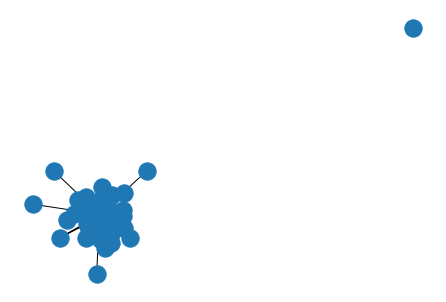

In [0]:
#nx.draw(G)
bokeh_plot(G)

In [0]:
print(nx.number_connected_components(G))

2


Some basic summary statistics:

In [0]:
print(['Num_Nodes', G.number_of_nodes()])
print(['Num_Edges', G.number_of_edges()])
print(['Num Triangles', sum(nx.triangles(G).values())/3])
print(['Clustering Coef.', nx.transitivity(G)])
print()
print(['Connected Components', nx.number_connected_components(G)])

['Num_Nodes', 55]
['Num_Edges', 400]
['Num Triangles', 1371.0]
['Clustering Coef.', 0.5339478125405686]

['Connected Components', 2]


Lets check the degree distribution:

(array([13., 12.,  9.,  7.,  5.,  4.,  1.,  2.,  0.,  2.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <a list of 10 Patch objects>)

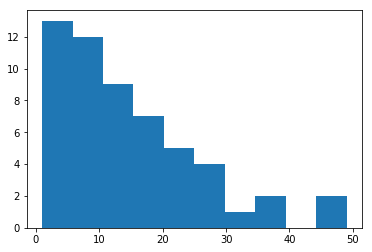

In [0]:
degrees = dict(nx.degree(G))
pylab.hist(list(dict(degrees).values()),10)

In [0]:
#ranking = ['Degree', dict(nx.degree(G))]
#ranking = ['Katz', nx.centrality.katz_centrality_numpy(G)]
#ranking = ['Page-Rank', nx.pagerank(G)]
ranking = ['Betweenness', nx.betweenness_centrality(G)]
bokeh_plot(G,ranking[1], ranking[0] + ' Centrality')

In [0]:
# try community detection
partition = community.best_partition(G)
print(str(max(partition.values())) + ' communities detected')

bokeh_plot(G,partition,'Communities',factor=True)

10 communities detected
